# **tf.gradients(y, [xs])**
- y가 list일 경우 그 안에 있는 값들이 모두 더해짐
- partial derivative of y with respect to xs
- 아웃풋은 len(xs)를 가지게 됨
- y : cost
- xs : trainable variable
- grad_ys: y 자기자신을 미분했을 때 사용되는 초기값을 부여(default=1) # 강화학습

In [24]:
import tensorflow as tf

In [25]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

In [26]:
tf.reset_default_graph()

In [27]:
x = tf.get_variable(name='x', initializer=-2.0)
y = tf.get_variable(name='y', initializer=5.0)
z = tf.get_variable(name='z', initializer=-4.0)

In [28]:
q = x + y
f = q * z

<p align="center"> <img width="600" height="auto" src="./picture/gradient_01.jpg"> </p>

$$\frac{\partial f}{\partial f}, \frac{\partial f}{\partial q},\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}, \frac{\partial f}{\partial z}$$

In [50]:
grad_tmp = tf.gradients([x,q], [x,y])
grad_tmp

[2.0, 1.0]


In [47]:
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(tf.gradients([x], [x])))

[1.0]


In [40]:
tf.gradients([x], [q])

[None]

In [48]:
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(tf.gradients([q], [x])))

[1.0]


In [51]:
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(tf.gradients([q], [y])))
    

[1.0]


In [7]:
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    tmp = sess.run(grad_tmp)
    print(tmp)

[2, 1]


In [8]:
grad_f = tf.gradients(f, [f, q, x, y, z]) # grad_ys

In [9]:
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    g_f, g_q, g_x, g_y, g_z = sess.run(grad_f)

In [10]:
print('f:', g_f)
print('q:', g_q)
print('x:', g_x)
print('y:', g_y)
print('z:', g_z)

f: 1
q: -4
x: -4
y: -4
z: 3


<p align="center"> <img width="600" height="auto" src="./picture/gradient_02.jpg"> </p>

- **stop.gradient**

In [52]:
# without stop.gradient
a = tf.constant(0.)
b = 2 * a
g = tf.gradients(a + b, [a, b])

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(g))

[3.0, 1.0]


In [12]:
# with stop.gradient
a = tf.constant(0.)
b = 2 * a
g_stop = tf.gradients(a + b, [a, b] ,stop_gradients=[a,b])

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(g_stop)) # 

[1.0, 1.0]


In [13]:
# another way
a = tf.stop_gradient(tf.constant(0.))
b = tf.stop_gradient(2 * a)
g = tf.gradients(a + b, [a, b])


with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(g))

[1.0, 1.0]


# **optimizer***


- **fine-tunning할 때 특정 파라미터만 학습시키고 싶을 때 주로 사용되는 방식**

```python
optimizer = tf.train.AdagradOptimzer(0.01)

first_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                     "scope/prefix/for/first/vars")
first_train_op = optimizer.minimize(cost, var_list=first_train_vars)

second_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                      "scope/prefix/for/second/vars")                     
second_train_op = optimizer.minimize(cost, var_list=second_train_vars)
```

- 03_model에서 사용되었던 데이터와 코드를 그대로 불러왔음

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

def data_partition(x,y):
    idx = np.arange(len(x))
    np.random.shuffle(idx)

    trn_idx = idx[:int(len(x)*0.6)] # 60%
    val_idx = idx[int(len(x)*0.6):int(len(x)*0.8)] # 20%
    tst_idx = idx[int(len(x)*0.8):] # 20%
    
    return {'train': {'x': x[trn_idx], 
                      'y': y[trn_idx]},
            'valid': {'x': x[val_idx],
                     'y': y[val_idx]},
            'test': {'x': x[tst_idx],
                     'y': y[tst_idx]}
           }


path = 'dataset/regression.csv'

df= pd.read_csv(path)
x = df['X'].values.reshape(-1,1)
y = df['Y'].values.reshape(-1,1)

data_dict = data_partition(x,y)

---

1) **Graph 생성**


In [15]:
tf.reset_default_graph()

- graph에 흘려보내는 데이터

In [16]:
X = tf.placeholder(shape=[None, 1], dtype=tf.float32, name = 'X')
Y = tf.placeholder(shape=[None, 1], dtype=tf.float32, name = 'Y')

- graph의 학습 파라미터

In [17]:
W = tf.get_variable(name='weight', shape=[1,1], initializer=tf.zeros_initializer())
b = tf.get_variable(name='bias', shape=[1,1], initializer=tf.zeros_initializer()) # trainable
print(W)
print(b)

<tf.Variable 'weight:0' shape=(1, 1) dtype=float32_ref>
<tf.Variable 'bias:0' shape=(1, 1) dtype=float32_ref>


- 모델 생성

In [18]:
Y_predicted = tf.matmul(X,W)+b 
Y_predicted

<tf.Tensor 'add:0' shape=(?, 1) dtype=float32>

- 손실함수(목적함수) 정의

In [19]:
loss = tf.reduce_mean(tf.square(Y-Y_predicted))
loss

<tf.Tensor 'Mean:0' shape=() dtype=float32>

--- 

- **optimizer를 사용하여 특정한 변수(파라미터, 레이어)만 학습***

In [20]:
tf.get_collection(key=tf.GraphKeys.TRAINABLE_VARIABLES)

[<tf.Variable 'weight:0' shape=(1, 1) dtype=float32_ref>,
 <tf.Variable 'bias:0' shape=(1, 1) dtype=float32_ref>]

In [21]:
train_var = tf.get_collection(key=tf.GraphKeys.TRAINABLE_VARIABLES, scope='bias')
train_var

[<tf.Variable 'bias:0' shape=(1, 1) dtype=float32_ref>]

- 최적화

In [22]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

train_op = optimizer.minimize(loss, var_list=train_var)

---

2) **Session 사용하여 Operation(Op) 수행**

In [23]:
batch_size =4

trn_batch_num = math.ceil(len(data_dict['train']['x'])/batch_size)
val_batch_num = math.ceil(len(data_dict['valid']['x'])/batch_size)
tst_batch_num = math.ceil(len(data_dict['test']['x'])/batch_size)

In [24]:
sess =tf.Session(config=config)
sess.run(tf.global_variables_initializer())

train_cumulative_loss = []    
valid_cumulative_loss = []
for i in range(1000):

    # training
    train_batch_loss = []
    for m in range(trn_batch_num):
        start = m*batch_size
        end = m*batch_size+batch_size
        x_batch = data_dict['train']['x'][start:end]
        y_batch = data_dict['train']['y'][start:end]
        _, _loss = sess.run([train_op, loss], feed_dict={X: x_batch, Y: y_batch})
        train_batch_loss.append(_loss)

    # development
    valid_batch_loss = []
    for m in range(val_batch_num):
        start = m*batch_size
        end = m*batch_size+batch_size
        x_batch = data_dict['valid']['x'][start:end]
        y_batch = data_dict['valid']['y'][start:end]
        _loss = sess.run(loss, feed_dict={X: x_batch, Y: y_batch})
        valid_batch_loss.append(_loss)

    train_cumulative_loss.append(np.mean(train_batch_loss))
    valid_cumulative_loss.append(np.mean(valid_batch_loss))
    if i % 200 == 0:
        print('epoch {}:'.format(str(i).zfill(3)), 
              'trn_loss({})'.format(np.mean(train_batch_loss)), 
              'val_loss({})'.format(np.mean(valid_batch_loss)))

epoch 000: trn_loss(1030.3487548828125) val_loss(4108.66552734375)
epoch 200: trn_loss(475.522705078125) val_loss(3053.429931640625)
epoch 400: trn_loss(247.3553009033203) val_loss(2454.707275390625)
epoch 600: trn_loss(184.03115844726562) val_loss(2162.872802734375)
epoch 800: trn_loss(175.006591796875) val_loss(2056.95751953125)


In [25]:
sess.run(W)

array([[0.]], dtype=float32)

In [26]:
sess.run(b)

array([[29.120178]], dtype=float32)

In [27]:
sess.close()

---

- **Vanishing/exploding gradients**

<p align="center"> <img width="600" height="auto" src="./picture/exploding gradients.jpg"> </p>

1) **Graph 생성**


In [28]:
tf.reset_default_graph()

- graph에 흘려보내는 데이터

In [29]:
X = tf.placeholder(shape=[None, 1], dtype=tf.float32, name = 'X')
Y = tf.placeholder(shape=[None, 1], dtype=tf.float32, name = 'Y')

- graph의 학습 파라미터

In [30]:
W = tf.get_variable(name='weight', shape=[1,1], initializer=tf.zeros_initializer())
b = tf.get_variable(name='bias', shape=[1,1], initializer=tf.zeros_initializer()) # trainable
print(W)
print(b)

<tf.Variable 'weight:0' shape=(1, 1) dtype=float32_ref>
<tf.Variable 'bias:0' shape=(1, 1) dtype=float32_ref>


- 모델 생성

In [31]:
Y_predicted = tf.matmul(X,W)+b 
Y_predicted

<tf.Tensor 'add:0' shape=(?, 1) dtype=float32>

- 손실함수(목적함수) 정의

In [32]:
loss = tf.reduce_mean(tf.square(Y-Y_predicted))
loss

<tf.Tensor 'Mean:0' shape=() dtype=float32>

---

- 최적화

In [33]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

- optimizer 함수를 사용하여 그래디언트를 컨트롤 할 수 있음
    - gradient는 (gradient, trainable variable) 한쌍으로 생성됨

In [34]:
grad_var = optimizer.compute_gradients(loss)
grad_var

[(<tf.Tensor 'gradients/MatMul_grad/tuple/control_dependency_1:0' shape=(1, 1) dtype=float32>,
  <tf.Variable 'weight:0' shape=(1, 1) dtype=float32_ref>),
 (<tf.Tensor 'gradients/add_grad/tuple/control_dependency_1:0' shape=(1, 1) dtype=float32>,
  <tf.Variable 'bias:0' shape=(1, 1) dtype=float32_ref>)]

In [35]:
clipped_grad = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in grad_var]
clipped_grad

[(<tf.Tensor 'clip_by_value:0' shape=(1, 1) dtype=float32>,
  <tf.Variable 'weight:0' shape=(1, 1) dtype=float32_ref>),
 (<tf.Tensor 'clip_by_value_1:0' shape=(1, 1) dtype=float32>,
  <tf.Variable 'bias:0' shape=(1, 1) dtype=float32_ref>)]

In [36]:
# instead of minimizing
train_op = optimizer.apply_gradients(clipped_grad)

---

2) **Session 사용하여 Operation(Op) 수행**

In [37]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

sess =tf.Session(config=config)
sess.run(tf.global_variables_initializer())

train_cumulative_loss = []    
valid_cumulative_loss = []
for i in range(1000):

    # training
    train_batch_loss = []
    for m in range(trn_batch_num):
        start = m*batch_size
        end = m*batch_size+batch_size
        x_batch = data_dict['train']['x'][start:end]
        y_batch = data_dict['train']['y'][start:end]
        _, _loss = sess.run([train_op, loss], feed_dict={X: x_batch, Y: y_batch})
        train_batch_loss.append(_loss)

    # development
    valid_batch_loss = []
    for m in range(val_batch_num):
        start = m*batch_size
        end = m*batch_size+batch_size
        x_batch = data_dict['valid']['x'][start:end]
        y_batch = data_dict['valid']['y'][start:end]
        _loss = sess.run(loss, feed_dict={X: x_batch, Y: y_batch})
        valid_batch_loss.append(_loss)

    train_cumulative_loss.append(np.mean(train_batch_loss))
    valid_cumulative_loss.append(np.mean(valid_batch_loss))
    if i % 200 == 0:
        print('epoch {}:'.format(str(i).zfill(3)), 
              'trn_loss({})'.format(np.mean(train_batch_loss)), 
              'val_loss({})'.format(np.mean(valid_batch_loss)))

epoch 000: trn_loss(1012.2506103515625) val_loss(3937.87451171875)
epoch 200: trn_loss(175.70249938964844) val_loss(1068.615966796875)
epoch 400: trn_loss(125.7570571899414) val_loss(1135.9176025390625)
epoch 600: trn_loss(111.01216888427734) val_loss(1181.2779541015625)
epoch 800: trn_loss(101.0970687866211) val_loss(1236.82470703125)


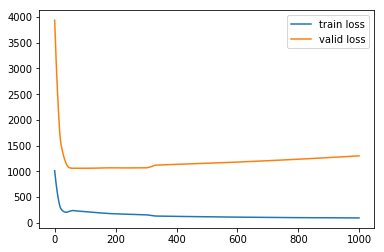

In [38]:
plt.plot(train_cumulative_loss, label = 'train loss')
plt.plot(valid_cumulative_loss, label = 'valid loss')
plt.legend()

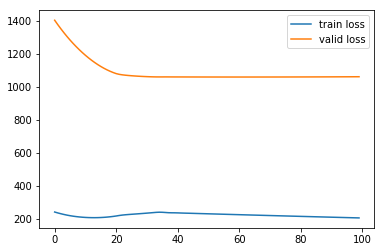

In [39]:
plt.plot(train_cumulative_loss[25:125], label = 'train loss')
plt.plot(valid_cumulative_loss[25:125], label = 'valid loss')
plt.legend()